# Discrete Elastic Rods
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

In [109]:
%pip install import-ipynb --quiet

Note: you may need to restart the kernel to use updated packages.


In [110]:
import import_ipynb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [111]:
def signedAngle(u = None,v = None,n = None):
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle
    return angle

In [112]:
def rotateAxisAngle(v = None,z = None,theta = None):
    if (theta == 0):
        vNew = v
    else:
        c = np.cos(theta)
        s = np.sin(theta)
        vNew = c * v + s * np.cross(z,v) + np.dot(z,v) * (1.0 - c) * z

    return vNew

In [113]:
def parallel_transport(u = None,t1 = None,t2 = None):

    # This function parallel transports a vector u from tangent t1 to t2
    # Input:
    # t1 - vector denoting the first tangent
    # t2 - vector denoting the second tangent
    # u - vector that needs to be parallel transported
    # Output:
    # d - vector after parallel transport

    b = np.cross(t1,t2)
    if (np.linalg.norm(b) == 0):
        d = u
    else:
        b = b / np.linalg.norm(b)
        # The following four lines may seem unnecessary but can sometimes help
        # with numerical stability
        b = b - np.dot(b,t1) * t1
        b = b / np.linalg.norm(b)
        b = b - np.dot(b,t2) * t2
        b = b / np.linalg.norm(b)
        n1 = np.cross(t1,b)
        n2 = np.cross(t2,b)
        d = np.dot(u,t1) * t2 + np.dot(u,n1) * n2 + np.dot(u,b) * b

    return d

In [114]:
def crossMat(a):
    A=np.matrix([[0,- a[2],a[1]],[a[2],0,- a[0]],[- a[1],a[0],0]])
    return A

#Functions to calculate reference twist and curvature

In [115]:
def computeReferenceTwist(a1e, a1f, t1, t2, refTwist = None):
    if refTwist is None:
      refTwist = 0
    P_a1e = parallel_transport(a1e, t1, t2)
    P_a1e_t = rotateAxisAngle(P_a1e, t2, refTwist)
    refTwist = refTwist + signedAngle(P_a1e_t, a1f, t2)
    return refTwist

In [116]:
def getRefTwist(a1, tangent, refTwist = None):

    # Given all the reference frames along the rod, we calculate the reference
    # twist along the rod on every node.

    ne = a1.shape[0] # ne is number of edges. Shape of a1 is ne x 3
    nv = ne + 1  # nv is number of nodes

    if refTwist is None: # No guess is provided
      refTwist = np.zeros(nv) # Intialize to all zeros.

    for c in np.arange(1,ne): # All internal nodes (i.e., all nodes except terminal nodes)
        a1e = a1[c-1,0:3]
        a1f = a1[c,  0:3]
        t1 =  tangent[c-1,0:3]
        t2 =  tangent[c,  0:3]
        refTwist[c] = computeReferenceTwist(a1e, a1f, t1, t2, refTwist[c])
    return refTwist

In [117]:
def computekappa(node0, node1, node2, m1e, m2e, m1f, m2f):
    t0 = (node1 - node0) / np.linalg.norm(node1 - node0)
    t1 = (node2 - node1) / np.linalg.norm(node2 - node1)

    kb = 2.0 * np.cross(t0,t1) / (1.0 + np.dot(t0,t1))
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    kappa = np.zeros(2)
    kappa[0] = kappa1
    kappa[1] = kappa2

    return kappa

In [118]:
def getKappa(q, m1, m2):
    nv = (len(q) + 1) // 4  # nv is number of nodes
    ne = nv - 1  # ne is number of edges

    kappa = np.zeros((nv, 2))  # Initialize kappa array

    for c in range(2, nv):  # Loop over edges (from second to last)

        # Extract node positions from q
        node0 = q[4*c-8:4*c-5]
        node1 = q[4*c-4:4*c-1]
        node2 = q[4*c+0:4*c+3]

        # Extract m1 and m2 for the current and previous edges
        m1e = m1[c-2,:].flatten()  # m1 vector on c-1 th edge
        # Another option is m1e = np.squeeze(np.array(m1[c-2, :]))
        m2e = m2[c-2,:].flatten()  # m2 vector on c-1 th edge
        m1f = m1[c-1,:].flatten()  # m1 vector on c th edge
        m2f = m2[c-1,:].flatten()  # m2 vector on c th edge

        # Compute local curvature at each node
        kappa_local = computekappa(node0, node1, node2, m1e, m2e, m1f, m2f)

        # Store the curvature values
        kappa[c-1, 0] = kappa_local[0]
        kappa[c-1, 1] = kappa_local[1]

    return kappa

# Functions to compute the frames (material frame and reference frame)

In [119]:
def computeTangent(q):
  # q is the DOF vector of size 4*nv - 1 = 3 * nv + ne
  nv = (len(q) + 1) // 4
  ne = nv - 1
  tangent = np.zeros((ne, 3))  # every edge has a tangent
  for c in range(ne):
    node0 = q[4*c:4*c+3]
    node1 = q[4*c+4:4*c+7]
    edge = node1 - node0
    tangent[c, :] = edge / np.linalg.norm(edge)
  return tangent

In [120]:
def computeMaterialDirectors(a1, a2, theta):
  # a1 = matrix of size ne x 3 - First reference director
  # a2 = matrix of size ne x 3
  # theta = vector of size ne (extracted from the DOF vector; every fourth element of the DOF vector)
  ne = len(theta) # Number of edges
  m1 = np.zeros_like(a1) # First material director
  m2 = np.zeros_like(a2) # Second material director
  for c in range(ne): # Loop over every edge
    cs = np.cos(theta[c])
    sn = np.sin(theta[c])
    m1[c, :] = cs * a1[c, :] + sn * a2[c, :]
    m2[c, :] = - sn * a1[c,:] + cs * a2[c, :]
  return m1, m2

In [121]:
def computeSpaceParallel(u1_first, q):
  # u1_first = first reference frame vector (arbitrary but orthonormal adapted) on the first edge
  # q is the DOF vector of size 4*nv - 1
  nv = (len(q)+1) // 4
  ne = nv -1

  tangent = computeTangent(q) # Get the tangent of each edge

  u1 = np.zeros((ne, 3)) # First reference frame director
  u2 = np.zeros((ne, 3)) # Second reference frame director

  u1_first = u1_first / np.linalg.norm(u1_first) # Ensure it is unit

  # First edge
  u1[0,:] = u1_first
  t0 = tangent[0,:]
  u2[0,:] = np.cross(t0, u1_first)
  u2[0,:] = u2[0,:] / np.linalg.norm(u2[0,:]) # Ensure it is unit

  for c in np.arange(1, ne):
    t0 = tangent[c-1,:] # "From" tangent
    t1 = tangent[c,:] # "To" tangent
    u1[c,:] = parallel_transport(u1[c-1,:], t0, t1)
    u1[c, :] = u1[c,:] / np.linalg.norm(u1[c,:]) # Ensure it is unit
    u2[c,:] = np.cross(t1, u1[c,:])
    u2[c, :] = u2[c,:] / np.linalg.norm(u2[c,:]) # Ensure it is unit

  return u1, u2

In [122]:
def computeTimeParallel(a1_old, q0, q):
  # a1_old: First time parallel frame director in "old" configuration
  # q0: "old" shape of the rod or DOF vector
  # q: "new" shape (a1 on this new shape is unknown)

  nv = (len(q)+1) // 4
  ne = nv -1

  tangent0 = computeTangent(q0) # Get the tangents in old configuration
  tangent = computeTangent(q) # Get the tangents in new configuration

  a1 = np.zeros((ne, 3)) # First time parallel frame director
  a2 = np.zeros((ne, 3)) # Second time parallel frame director

  for c in np.arange(ne): # Loop over every edge
    t0 = tangent0[c,:] # old tangent on the c-th edge
    t1 = tangent[c,:] # new tangent on the c-th edge
    a1[c,:] = parallel_transport(a1_old[c,:], t0, t1)
    a1[c,:] = a1[c,:] - np.dot(a1[c,:], t1) * t1 # Ensure it is orthogonal to t1
    a1[c, :] = a1[c,:] / np.linalg.norm(a1[c,:]) # Ensure it is unit
    a2[c, :] = np.cross(t1, a1[c,:])
    a2[c,:] = a2[c,:] - np.dot(a2[c,:], t1) * t1 # Ensure it is orthogonal to t1
    a2[c, :] = a2[c,:] / np.linalg.norm(a2[c,:]) # Ensure it is unit

  return a1, a2

# Gradients and Hessians of Elastic Energies

In [123]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

In [124]:
def gradEb_hessEb(node0 = None,node1 = None,node2 = None,m1e = None,m2e = None,m1f = None,m2f = None,kappaBar = None,l_k = None, EI1 = None, EI2 = None):

# This function follows the formulation by Panetta et al. 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "turning" node
# node1: 1x3 vector - position of the "turning" node
# node2: 1x3 vector - position of the node after the "turning" node

# m1e: 1x3 vector - material director 1 of the edge prior to turning
# m2e: 1x3 vector - material director 2 of the edge prior to turning
# m1f: 1x3 vector - material director 1 of the edge after turning
# m2f: 1x3 vector - material director 2 of the edge after turning

# kappaBar: 1x2 vector - natural curvature at the turning node
# l_k: voronoi length (undeformed) of the turning node
# EI1: scalar - bending stiffness for kappa1
# EI2: scalar - bending stiffness for kappa2

# Outputs:
# dF: 11x1  vector - gradient of the bending energy at node1.
# dJ: 11x11 vector - hessian of the bending energy at node1.

    # If EI2 is not specified, set it equal to EI1
    if EI2 == None:
        EI2 = EI1

    #
    ## Computation of gradient of the two curvatures
    #
    gradKappa = np.zeros((11,2))

    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))
    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    tilde_d1 = (m1e + m1f) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvatures
    kappa1 = 0.5 * np.dot(kb,m2e + m2f)
    kappa2 = - 0.5 * np.dot(kb,m1e + m1f)

    Dkappa1De = 1.0 / norm_e * (- kappa1 * tilde_t + np.cross(tf,tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (- kappa1 * tilde_t - np.cross(te,tilde_d2))
    Dkappa2De = 1.0 / norm_e * (- kappa2 * tilde_t - np.cross(tf,tilde_d1))
    Dkappa2Df = 1.0 / norm_f * (- kappa2 * tilde_t + np.cross(te,tilde_d1))
    gradKappa[0:3,1-1] = - Dkappa1De
    gradKappa[4:7,1-1] = Dkappa1De - Dkappa1Df
    gradKappa[8:11,1-1] = Dkappa1Df
    gradKappa[0:3,2-1] = - Dkappa2De
    gradKappa[4:7,2-1] = Dkappa2De - Dkappa2Df
    gradKappa[8:11,2-1] = Dkappa2Df
    gradKappa[4-1,1-1] = - 0.5 * np.dot(kb,m1e)
    gradKappa[8-1,1-1] = - 0.5 * np.dot(kb,m1f)
    gradKappa[4-1,2-1] = - 0.5 * np.dot(kb,m2e)
    gradKappa[8-1,2-1] = - 0.5 * np.dot(kb,m2f)

    #
    ## Computation of hessian of the two curvatures
    #
    DDkappa1 = np.zeros((11,11)) # Hessian of kappa1
    DDkappa2 = np.zeros((11,11)) # Hessian of kappa2

    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2

    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf,tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d2t = np.transpose(tf_c_d2t_o_tt)
    kb_o_d2e = np.outer(kb, m2e)
    d2e_o_kb = np.transpose(kb_o_d2e) # Not used in Panetta 2019
    te_o_te = np.outer(te, te)
    Id3 = np.eye(3)

    # Bergou 2010
    # D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (4.0 * norm2_e) * (kb_o_d2e + d2e_o_kb)
    # Panetta 2019
    D2kappa1De2 = 1.0 / norm2_e * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tt_o_tf_c_d2t) - kappa1 / (chi * norm2_e) * (Id3 - te_o_te ) + 1.0 / (2.0 * norm2_e) * (kb_o_d2e)


    tmp = np.cross(te,tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = np.transpose(te_c_d2t_o_tt)
    kb_o_d2f = np.outer(kb, m2f)
    d2f_o_kb = np.transpose(kb_o_d2f) # Not used in Panetta 2019
    tf_o_tf = np.outer( tf, tf )

    # Bergou 2010
    # D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (4.0 * norm2_f) * (kb_o_d2f + d2f_o_kb)
    # Panetta 2019
    D2kappa1Df2 = 1.0 / norm2_f * (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + tt_o_te_c_d2t) - kappa1 / (chi * norm2_f) * (Id3 - tf_o_tf) + 1.0 / (2.0 * norm2_f) * (kb_o_d2f)


    te_o_tf = np.outer(te, tf)
    D2kappa1DfDe = - kappa1 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DeDf = np.transpose(D2kappa1DfDe)

    tmp = np.cross(tf,tilde_d1)
    tf_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_tf_c_d1t = np.transpose(tf_c_d1t_o_tt)
    kb_o_d1e = np.outer(kb, m1e)
    d1e_o_kb = np.transpose(kb_o_d1e) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (4.0 * norm2_e) * (kb_o_d1e + d1e_o_kb)
    # Panetta 2019
    D2kappa2De2 = 1.0 / norm2_e * (2.0 * kappa2 * tt_o_tt + tf_c_d1t_o_tt + tt_o_tf_c_d1t) - kappa2 / (chi * norm2_e) * (Id3 - te_o_te) - 1.0 / (2.0 * norm2_e) * (kb_o_d1e)

    tmp = np.cross(te,tilde_d1)
    te_c_d1t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d1t = np.transpose(te_c_d1t_o_tt)
    kb_o_d1f = np.outer(kb, m1f)
    d1f_o_kb = np.transpose(kb_o_d1f) # Not used in Panetta 2019

    # Bergou 2010
    # D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (4.0 * norm2_f) * (kb_o_d1f + d1f_o_kb)
    # Panetta 2019
    D2kappa2Df2 = 1.0 / norm2_f * (2 * kappa2 * tt_o_tt - te_c_d1t_o_tt - tt_o_te_c_d1t) - kappa2 / (chi * norm2_f) * (Id3 - tf_o_tf) - 1.0 / (2.0 * norm2_f) * (kb_o_d1f)

    D2kappa2DfDe = - kappa2 / (chi * norm_e * norm_f) * (Id3 + te_o_tf) + 1.0 / (norm_e * norm_f) * (2 * kappa2 * tt_o_tt + tf_c_d1t_o_tt - tt_o_te_c_d1t + crossMat(tilde_d1))
    D2kappa2DeDf = np.transpose(D2kappa2DfDe)

    D2kappa1Dthetae2 = - 0.5 * np.dot(kb,m2e)
    D2kappa1Dthetaf2 = - 0.5 * np.dot(kb,m2f)
    D2kappa2Dthetae2 = 0.5 * np.dot(kb,m1e)
    D2kappa2Dthetaf2 = 0.5 * np.dot(kb,m1f)

    D2kappa1DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m1e) * tilde_t - 1.0 / chi * np.cross(tf,m1e))
    D2kappa1DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m1f) * tilde_t - 1.0 / chi * np.cross(tf,m1f))
    D2kappa1DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m1e) * tilde_t + 1.0 / chi * np.cross(te,m1e))
    D2kappa1DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m1f) * tilde_t + 1.0 / chi * np.cross(te,m1f))
    D2kappa2DeDthetae = 1.0 / norm_e * (0.5 * np.dot(kb,m2e) * tilde_t - 1.0 / chi * np.cross(tf,m2e))
    D2kappa2DeDthetaf = 1.0 / norm_e * (0.5 * np.dot(kb,m2f) * tilde_t - 1.0 / chi * np.cross(tf,m2f))
    D2kappa2DfDthetae = 1.0 / norm_f * (0.5 * np.dot(kb,m2e) * tilde_t + 1.0 / chi * np.cross(te,m2e))
    D2kappa2DfDthetaf = 1.0 / norm_f * (0.5 * np.dot(kb,m2f) * tilde_t + 1.0 / chi * np.cross(te,m2f))

    # Curvature terms
    DDkappa1[0:3,0:3] = D2kappa1De2
    DDkappa1[0:3,4:7] = - D2kappa1De2 + D2kappa1DfDe
    DDkappa1[0:3,8:11] = - D2kappa1DfDe
    DDkappa1[4:7,0:3] = - D2kappa1De2 + D2kappa1DeDf
    DDkappa1[4:7,4:7] = D2kappa1De2 - D2kappa1DeDf - D2kappa1DfDe + D2kappa1Df2
    DDkappa1[4:7,8:11] = D2kappa1DfDe - D2kappa1Df2
    DDkappa1[8:11,0:3] = - D2kappa1DeDf
    DDkappa1[8:11,4:7] = D2kappa1DeDf - D2kappa1Df2
    DDkappa1[8:11,8:11] = D2kappa1Df2

    # Twist terms
    DDkappa1[4-1,4-1] = D2kappa1Dthetae2
    DDkappa1[8-1,8-1] = D2kappa1Dthetaf2

    # Curvature-twist coupled terms
    DDkappa1[0:3,4-1] = - D2kappa1DeDthetae
    DDkappa1[4:7,4-1] = D2kappa1DeDthetae - D2kappa1DfDthetae
    DDkappa1[8:11,4-1] = D2kappa1DfDthetae
    DDkappa1[4-1,0:3] = np.transpose(DDkappa1[0:3,4-1])
    DDkappa1[4-1,4:7] = np.transpose(DDkappa1[4:7,4-1])
    DDkappa1[4-1,8:11] = np.transpose(DDkappa1[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa1[0:3,8-1] = - D2kappa1DeDthetaf
    DDkappa1[4:7,8-1] = D2kappa1DeDthetaf - D2kappa1DfDthetaf
    DDkappa1[8:11,8-1] = D2kappa1DfDthetaf
    DDkappa1[8-1,0:3] = np.transpose(DDkappa1[0:3,8-1])
    DDkappa1[8-1,4:7] = np.transpose(DDkappa1[4:7,8-1])
    DDkappa1[8-1,8:11] = np.transpose(DDkappa1[8:11,8-1])

    # Curvature terms
    DDkappa2[0:3,0:3] = D2kappa2De2
    DDkappa2[0:3,4:7] = - D2kappa2De2 + D2kappa2DfDe
    DDkappa2[0:3,8:11] = - D2kappa2DfDe
    DDkappa2[4:7,0:3] = - D2kappa2De2 + D2kappa2DeDf
    DDkappa2[4:7,4:7] = D2kappa2De2 - D2kappa2DeDf - D2kappa2DfDe + D2kappa2Df2
    DDkappa2[4:7,8:11] = D2kappa2DfDe - D2kappa2Df2
    DDkappa2[8:11,0:3] = - D2kappa2DeDf
    DDkappa2[8:11,4:7] = D2kappa2DeDf - D2kappa2Df2
    DDkappa2[8:11,8:11] = D2kappa2Df2

    # Twist terms
    DDkappa2[4-1,4-1] = D2kappa2Dthetae2
    DDkappa2[8-1,8-1] = D2kappa2Dthetaf2

    # Curvature-twist coupled terms
    DDkappa2[0:3,4-1] = - D2kappa2DeDthetae
    DDkappa2[4:7,4-1] = D2kappa2DeDthetae - D2kappa2DfDthetae
    DDkappa2[8:11,4-1] = D2kappa2DfDthetae
    DDkappa2[4-1,0:3] = np.transpose(DDkappa2[0:3,4-1])
    DDkappa2[4-1,4:7] = np.transpose(DDkappa2[4:7,4-1])
    DDkappa2[4-1,8:11] = np.transpose(DDkappa2[8:11,4-1])

    # Curvature-twist coupled terms
    DDkappa2[0:3,8-1] = - D2kappa2DeDthetaf
    DDkappa2[4:7,8-1] = D2kappa2DeDthetaf - D2kappa2DfDthetaf
    DDkappa2[8:11,8-1] = D2kappa2DfDthetaf
    DDkappa2[8-1,0:3] = np.transpose(DDkappa2[0:3,8-1])
    DDkappa2[8-1,4:7] = np.transpose(DDkappa2[4:7,8-1])
    DDkappa2[8-1,8:11] = np.transpose(DDkappa2[8:11,8-1])

    #
    ## Gradient of Eb
    #
    EIMat = np.array([[EI1, 0], [0, EI2]])
    kappaVector = np.array([kappa1, kappa2])
    dkappaVector = kappaVector - kappaBar
    gradKappa_1 = gradKappa[:,0]
    gradKappa_2 = gradKappa[:,1]
    dE_dKappa1 = EI1 / l_k * dkappaVector[0] # Gradient of Eb wrt kappa1
    dE_dKappa2 = EI2 / l_k * dkappaVector[1] # Gradient of Eb wrt kappa2
    d2E_dKappa11 = EI1 / l_k # Second gradient of Eb wrt kappa1
    d2E_dKappa22 = EI2 / l_k # Second gradient of Eb wrt kappa2

    # dF is the gradient of Eb wrt DOFs
    dF = dE_dKappa1 * gradKappa_1 + dE_dKappa2 * gradKappa_2

    # Hessian of Eb
    gradKappa1_o_gradKappa1 = np.outer(gradKappa_1, gradKappa_1)
    gradKappa2_o_gradKappa2 = np.outer(gradKappa_2, gradKappa_2)
    dJ = dE_dKappa1 * DDkappa1 + dE_dKappa2 * DDkappa2 + d2E_dKappa11 * gradKappa1_o_gradKappa1 + d2E_dKappa22 * gradKappa2_o_gradKappa2

    return dF,dJ

In [125]:
def gradEt_hessEt(node0 = None,node1 = None,node2 = None,theta_e = None,
    theta_f = None,refTwist = None,twistBar = None,l_k = None,GJ = None):

# Formulation due to Panetta 2019

# Inputs:
# node0: 1x3 vector - position of the node prior to the "twisting" node
# node1: 1x3 vector - position of the "twisting" node
# node2: 1x3 vector - position of the node after the "twisting" node

# theta_e: scalar - twist angle of the first edge
# theta_f: scalar - twist angle of the second (last) edge

# l_k: voronoi length (undeformed) of the turning node
# refTwist: reference twist (unit: radian) at the node
# twistBar: undeformed twist (unit: radian) at the node
# GJ: scalar - twisting stiffness

# Outputs:
# dF: 11x1  vector - gradient of the twisting energy at node1.
# dJ: 11x11 vector - hessian of the twisting energy at node1.

    gradTwist = np.zeros(11)
    ee = node1 - node0
    ef = node2 - node1
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)
    norm2_e = norm_e ** 2
    norm2_f = norm_f ** 2
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te,tf) / (1.0 + np.dot(te,tf))

    # Gradient of twist wrt DOFs
    gradTwist[0:3] = - 0.5 / norm_e * kb
    gradTwist[8:11] = 0.5 / norm_f * kb
    gradTwist[4:7] = - (gradTwist[0:3] + gradTwist[8:11])
    gradTwist[4-1] = - 1
    gradTwist[8-1] = 1

    chi = 1.0 + np.dot(te,tf)
    tilde_t = (te + tf) / chi
    te_plus_tilde_t = te + tilde_t;
    kb_o_te = np.outer(kb, te_plus_tilde_t)
    te_o_kb = np.outer(te_plus_tilde_t, kb)
    tf_plus_tilde_t = tf + tilde_t
    kb_o_tf = np.outer(kb, tf_plus_tilde_t)
    tf_o_kb = np.outer(tf_plus_tilde_t, kb)
    kb_o_tilde_t = np.outer(kb, tilde_t)

    ## Hessian of twist wrt DOFs
    DDtwist = np.zeros((11,11))
    # Bergou 2010 Formulation is below.
    # D2mDe2 = - 0.25 / norm2_e * (kb_o_te + te_o_kb)
    # D2mDf2 = - 0.25 / norm2_f * (kb_o_tf + tf_o_kb)
    # D2mDeDf = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - kb_o_tilde_t)
    # D2mDfDe = np.transpose(D2mDeDf)
    # Panetta 2019 formulation
    D2mDe2 = -0.5 / norm2_e * (np.outer(kb, (te + tilde_t)) + 2.0 / chi * crossMat(tf))
    D2mDf2 = -0.5 / norm2_f * (np.outer(kb, (tf + tilde_t)) - 2.0 / chi * crossMat(te))
    D2mDfDe = 0.5 / (norm_e * norm_f) * (2.0 / chi * crossMat(te) - np.outer(kb, tilde_t)) # CAREFUL: D2mDfDe means \partial^2 m/\partial e^i \partial e^{i-1}
    D2mDeDf = 0.5 / (norm_e * norm_f) * (-2.0 / chi * crossMat(tf) - np.outer(kb, tilde_t))

    # See Line 1145 of https://github.com/jpanetta/ElasticRods/blob/master/ElasticRod.cc
    DDtwist[0:3,0:3] = D2mDe2
    DDtwist[0:3,4:7] = - D2mDe2 + D2mDfDe
    DDtwist[4:7,0:3] = - D2mDe2 + D2mDeDf
    DDtwist[4:7,4:7] = D2mDe2 - (D2mDeDf + D2mDfDe) + D2mDf2
    DDtwist[0:3,8:11] = - D2mDfDe
    DDtwist[8:11,0:3] = - D2mDeDf
    DDtwist[8:11,4:7] = D2mDeDf - D2mDf2
    DDtwist[4:7,8:11] = D2mDfDe - D2mDf2
    DDtwist[8:11,8:11] = D2mDf2

    ## Gradients and Hessians of energy with respect to twist
    integratedTwist = theta_f - theta_e + refTwist - twistBar
    dE_dTau = GJ / l_k * integratedTwist
    d2E_dTau2 = GJ / l_k

    ## Gradient of Et
    dF = dE_dTau * gradTwist
    ## Hessian of Eb
    gradTwist_o_gradTwist = np.outer( gradTwist, gradTwist )
    dJ = dE_dTau * DDtwist + d2E_dTau2 * gradTwist_o_gradTwist
    return dF,dJ

#Plot the rod

In [126]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [127]:
def plotrod(q, a1, a2, m1, m2, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - a1, a2: Reference frames (director vectors).
    - m1, m2: Material directors.
    - ctime: Current time for title.
    DO NOT USE THIS PLOTTING FUNCTION.
    """

    nv = (len(q) + 1) // 4
    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    # Compute the length of the rod
    L = np.sum(np.sqrt((x1[1:] - x1[:-1])**2 +
                       (x2[1:] - x2[:-1])**2 +
                       (x3[1:] - x3[:-1])**2))

    # Scale the director vectors by 0.1 * L
    a1 *= 0.1 * L # PROBLEM!
    a2 *= 0.1 * L
    m1 *= 0.1 * L
    m2 *= 0.1 * L

    # Create figure and set up 3D plotting
    fig = plt.figure(1)
    clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Plot the directors along the rod
    for c in range(nv - 1):
        xa = q[4 * c : 4 * c + 3]
        xb = q[4 * c + 4 : 4 * c + 7]
        xp = (xa + xb) / 2  # Midpoint between xa and xb

        # Plot the a1, a2, m1, m2 vectors at the midpoint
        ax.plot3D([xp[0], xp[0] + a1[c, 0]], [xp[1], xp[1] + a1[c, 1]],
                  [xp[2], xp[2] + a1[c, 2]], 'b--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + a2[c, 0]], [xp[1], xp[1] + a2[c, 1]],
                  [xp[2], xp[2] + a2[c, 2]], 'c--', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m1[c, 0]], [xp[1], xp[1] + m1[c, 1]],
                  [xp[2], xp[2] + m1[c, 2]], 'r-', linewidth=2)
        ax.plot3D([xp[0], xp[0] + m2[c, 0]], [xp[1], xp[1] + m2[c, 1]],
                  [xp[2], xp[2] + m2[c, 2]], 'g-', linewidth=2)

    # Add legend
    ax.legend(['a1', 'a2', 'm1', 'm2'])

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling using the custom function
    set_axes_equal(ax)

    plt.draw()  # Force a redraw of the figure
    plt.show()

In [128]:
def plotrod_simple(q, ctime):
    """
    Function to plot the rod with the position and directors.

    Parameters:
    - q: Position vector (DOF vector).
    - ctime: Current time for title.
    """

    x1 = q[0::4]
    x2 = q[1::4]
    x3 = q[2::4]

    fig = plt.figure(1)
    #clear_output()
    plt.clf()  # Clear the figure
    ax = fig.add_subplot(111, projection='3d')

    # Plot the rod as black circles connected by lines
    ax.plot3D(x1, x2, x3, 'ko-')

    # Plot the first node with a red triangle
    ax.plot3D([x1[0]], [x2[0]], [x3[0]], 'r^')

    # Set the title with current time
    ax.set_title(f't={ctime:.2f}')

    # Set axes labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    # Set equal scaling and a 3D view
    set_axes_equal(ax)
    plt.draw()  # Force a redraw of the figure

    plt.show()

# Functions to evaluate elastic forces given the DOF vector

In [129]:
def getFs(q, EA, refLen):
  # STRETCHING
  # Input q is a DOF vector of size 4*nv - 1
  # Output is the stretching force vector (size 4*nv-1) and it's gradient w.r.t. q (square matrix)
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Fs = np.zeros(ndof)
  Js = np.zeros((ndof, ndof))

  # Loop over each stretching spring
  for c in range(ne):
    xa = q[4 * c : 4 * c + 3]
    xb = q[4 * c + 4 : 4 * c + 7]
    ind = np.array([4*c, 4*c+1, 4*c+2, 4*c+4, 4*c+5, 4*c+6])
    dL = refLen[c]

    dF, dJ = gradEs_hessEs(xa, xb, dL, EA)

    Fs[ind] -= dF
    Js[np.ix_(ind, ind)] -= dJ

  return Fs, Js

In [130]:
def getFb(q, m1, m2, kappaBar, EI, voronoiRefLen):
  # BENDING
  # Input q is a DOF vector of size 4*nv - 1
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Fb = np.zeros(ndof)
  Jb = np.zeros((ndof, ndof))

  # Loop over each bending spring
  for c in range(1, ne): # Ignore the terminal nodes (0 and nv)
    node0 = q[4 * (c - 1) : 4 * (c - 1) + 3] # (c-1)-th node
    node1 = q[4 * c : 4*c + 3] # c-th node
    node2 = q[4 * (c + 1) : 4 * (c + 1) + 3] # (c+1)-th node
    # Calculate bending force due to the turning at the c-th node

    m1e = m1[c - 1, 0:3]
    m2e = m2[c - 1, 0:3]
    m1f = m1[c,  0:3]
    m2f = m2[c,  0:3]

    dL = voronoiRefLen[c]
    curvature0 = kappaBar[c, 0:2]

    dF, dJ = gradEb_hessEb(node0, node1, node2, m1e, m2e, m1f, m2f, curvature0, dL, EI)
    ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,4*c, 4*c+1, 4*c+2, 4*c+3, 4*c+4, 4*c+5, 4*c+6])

    Fb[ind] -= dF
    Jb[np.ix_(ind, ind)] -= dJ

  return Fb, Jb

In [131]:
def getFt(q, refTwist, twistBar, GJ, voronoiRefLen):
  # TWISTING
  # Input q is a DOF vector of size 4*nv - 1
  ndof = len(q)
  nv = (ndof + 1) // 4
  ne = nv - 1

  Ft = np.zeros(ndof)
  Jt = np.zeros((ndof, ndof))

  # Loop over each twisting spring
  for c in range(1, ne): # Ignore the terminal nodes (0 and nv)
    node0 = q[4 * (c - 1) : 4 * (c - 1) + 3] # (c-1)-th node
    node1 = q[4 * c : 4*c + 3] # c-th node
    node2 = q[4 * (c + 1) : 4 * (c + 1) + 3] # (c+1)-th node
    theta_e = q[4*c-1]
    theta_f = q[4*c+3]
    # Calculate twisting force due to the turning at the c-th node

    dL = voronoiRefLen[c]

    dF, dJ = gradEt_hessEt(node0, node1, node2, theta_e, theta_f, refTwist[c], twistBar[c], dL, GJ)
    ind = np.array([4*c-4, 4*c-3, 4*c-2, 4*c-1,4*c, 4*c+1, 4*c+2, 4*c+3, 4*c+4, 4*c+5, 4*c+6])

    Ft[ind] -= dF
    Jt[np.ix_(ind, ind)] -= dJ

  return Ft, Jt

# Objective Function: Time stepping scheme

Given the old DOF, compute the new DOF

In [132]:
def objfun(qOld, uOld, a1_old, a2_old,
           freeIndex,
           dt, tol,
           refTwist,
           massVector, massMatrix,
           EA, refLen,
           EI, GJ, voronoiRefLen,
           kappaBar, twistBar,
           Fg):

  q_new = qOld.copy()
  iter = 0
  error = 10 * tol
  maxIter = 30 # maximum number of iterations

  mu = 0.2

  flag = True
  while error > tol:
    # Reference frame
    a1_new, a2_new = computeTimeParallel(a1_old, qOld, q_new) # Time parallel reference frame along the rod
    # Reference twist
    tangent = computeTangent(q_new)
    refTwist_new = getRefTwist(a1_new, tangent, refTwist) # Reference twist vector of size nv
    # Material frame
    theta = q_new[3::4]
    m1, m2 = computeMaterialDirectors(a1_new, a2_new, theta) # Material directors of size nv x 3

    # Computer elastic forces
    Fs, Js = getFs(q_new, EA, refLen)
    Fb, Jb = getFb(q_new, m1, m2, kappaBar, EI, voronoiRefLen)
    Ft, Jt = getFt(q_new, refTwist_new, twistBar, GJ, voronoiRefLen)

    Fh = - mu * (q_new - qOld) / dt
    Jh = - mu / dt * np.eye(ndof)

    # Compute forces
    Forces = Fs + Fb + Ft + Fg + Fh
    JForces = Js + Jb + Jt + Jh

    f = massVector / dt * ( (q_new - qOld) / dt - uOld ) - Forces
    J = massMatrix / dt**2 - JForces

    # Extract the free part
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]

    dq_free = np.linalg.solve(J_free, f_free) # J \ f

    q_new[freeIndex] -= dq_free
    error = np.sum(np.abs(f_free)) # Correction
    # Keep in mind that "error = np.sum(np.abs(dq_free))" is ok but tol should be computed based on length
    iter += 1

    if iter >= maxIter:
      print('Maximum number of iterations reached')
      flag = False
      break

  uNew = (q_new - qOld) / dt
  return q_new, uNew, a1_new, a2_new, flag

# Main Discrete Elastic Rods

**Geometry: Create a matrix of size $N \times 3$**

In [133]:
# Inputs
nv = 50 # number of nodes
ne = nv - 1
ndof = 3*nv + ne

# Helix parameters
r0 = 0.001 # cross-sectional radius of the rod # Given, d = 0.002 m
D = 0.04 # meter: helix diameter
pitch = 2 * r0 # Pitch is the same as the cross-sectional diameter
N = 5 # Number of turns
# a and b are parameters used in standard (wikipedia) definition of helix
a = D/2 # Helix radius
b = pitch / (2.0 * np.pi)
T = 2.0 * np.pi * N # Angle created by the helix (N turns in the center)
L = T * np.sqrt( a**2 + b ** 2) # Arc length of the helix
axial_l = N * pitch # Axial length

print('Helix diameter = ', D)
print('Pitch = ', pitch)
print('N = ', N)
print('Arc length = ', L)
Estimated_Arc = np.pi * D * N
print('Estimated arc length = ', Estimated_Arc)
print('axial_l = ', axial_l)

# Create our nodes matrix
nodes = np.zeros((nv, 3))
for c in range(nv):
  t = c * T / (nv - 1.0)
  nodes[c,0] = a * np.cos(t)
  nodes[c,1] = a * np.sin(t)
  nodes[c,2] = - b * t

Helix diameter =  0.04
Pitch =  0.002
N =  5
Arc length =  0.6283981031508404
Estimated arc length =  0.6283185307179586
axial_l =  0.01


**Elastic Stiffness**

In [134]:
# Material Parameters
Y = 10e6 # 10 MPa - Young's modulus
nu = 0.5 # Poisson's ration
G = Y / ( 2 * (1 + nu)) # Shear modulus

# Stiffness variables
EA = Y * np.pi * r0**2 # Stretching stiffness
EI = Y * np.pi * r0**4 / 4.0 # Bending stiffness
GJ = G * np.pi * r0**4 / 2.0 # Twisting stiffness

**Time Parameters**

In [135]:
totalTime = 50 # seconds - total time of the simulation
dt = 0.1 # TIme step size -- may need to be adjusted

timeSteps = int(totalTime / dt)
snapshots = 5
snapshotInterval = timeSteps // snapshots
print(snapshotInterval, ' time steps between snapshots')

# Tolerance
tol = EI / L ** 2 * 1e-3

100  time steps between snapshots


**Mass vector and matrix**

In [136]:
rho = 1000 # kg/m^3 -- density
totalM = L * np.pi * r0**2 * rho  # Total mass of the rod
dm = totalM / ne

massVector = np.zeros(ndof)
for c in range(nv):
  ind = [4*c, 4*c+1, 4*c+2] # x, y, z coordinates of c-th node
  if c == 0 or c == nv - 1:
    massVector[ind] = dm / 2
  else:
    massVector[ind] = dm

for c in range(ne):
  massVector[4*c+3] = 0.5 * dm * r0 ** 2 # Equation for a solid cylinder
  # Because r0 is really small, we may get away with just using 0 angular mass

massMatrix = np.diag(massVector)

**External Force: Point load on the last node (instead of gravity)**

In [137]:
F_end = EI / L ** 2
vectorLoad = np.array([0, 0, -F_end]) # Point load vector

Fg = np.zeros(ndof) # Eexternal force vector
c = nv-1
ind = [4*c, 4*c + 1, 4*c + 2] # last node
Fg[ind] += vectorLoad

**Initial DOF vector**

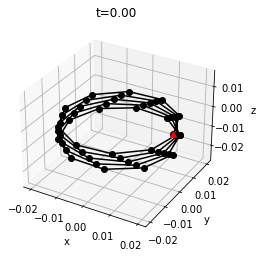

In [138]:
qOld = np.zeros(ndof)
for c in range(nv):
  ind = [4*c, 4*c + 1, 4*c + 2] # c-th node
  qOld[ind] = nodes[c, :]

uOld = np.zeros_like(qOld) # Velocity is zero initially

plotrod_simple(qOld, 0)

**Compute the reference lengths**

In [139]:
# Reference length of each edge
refLen = np.zeros(ne)
for c in range(ne):
  refLen[c] = np.linalg.norm(nodes[c + 1, :] - nodes[c, :])

voronoiRefLen = np.zeros(nv)
for c in range(nv):
  if c == 0:
    voronoiRefLen[c] = 0.5 * refLen[c]
  elif c == nv - 1:
    voronoiRefLen[c] = 0.5 * refLen[c - 1]
  else:
    voronoiRefLen[c] = 0.5 * (refLen[c - 1] + refLen[c])

**Compute the frames**

In [140]:
# Reference frame (At t=0, we initialize it with space parallel reference frame but not mandatory)
tangent = computeTangent(qOld)

t0 = tangent[0, :]
arb_v = np.array([0, 0, -1])
a1_first = np.cross(t0, arb_v) / np.linalg.norm(np.cross(t0, arb_v))
if np.linalg.norm(np.cross(t0, arb_v)) < 1e-3: # Check if t0 and arb_v are parallel
  arb_v = np.array([0, 1, 0])
  a1_first = np.cross(t0, arb_v) / np.linalg.norm(np.cross(t0, arb_v))

a1, a2 = computeSpaceParallel(a1_first, qOld)

# Material frame
theta = qOld[3::4] # Extract theta angles
m1, m2 = computeMaterialDirectors(a1, a2, theta)

In [141]:
# plotrod(qOld, a1, a2, m1, m2, 0.0) # Correction

**Natural Curvature and Twist**

In [142]:
# Reference twist
refTwist = np.zeros(nv) # Or use the function we computed

# Natural curvature
kappaBar = getKappa(qOld, m1, m2)

# Natural twist
twistBar = np.zeros(nv)

**Set up boundary conditions: First two nodes and first theta angle is fixed**

In [143]:
# Fixed and free DOFs
fixedIndex = np.arange(0, 7)
freeIndex = np.arange(7, ndof)
# If we include the x and y coordinates of the last node as FIXED DOFs, we will get better agreement

**Time stepping loop**

Current time:  0


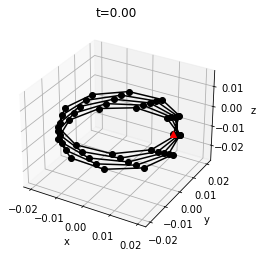

Current time:  0.1
Current time:  0.2
Current time:  0.30000000000000004
Current time:  0.4
Current time:  0.5
Current time:  0.6
Current time:  0.7
Current time:  0.7999999999999999
Current time:  0.8999999999999999
Current time:  0.9999999999999999
Current time:  1.0999999999999999
Current time:  1.2
Current time:  1.3
Current time:  1.4000000000000001
Current time:  1.5000000000000002
Current time:  1.6000000000000003
Current time:  1.7000000000000004
Current time:  1.8000000000000005
Current time:  1.9000000000000006
Current time:  2.0000000000000004
Current time:  2.1000000000000005
Current time:  2.2000000000000006
Current time:  2.3000000000000007
Current time:  2.400000000000001
Current time:  2.500000000000001
Current time:  2.600000000000001
Current time:  2.700000000000001
Current time:  2.800000000000001
Current time:  2.9000000000000012
Current time:  3.0000000000000013
Current time:  3.1000000000000014
Current time:  3.2000000000000015
Current time:  3.3000000000000016
Cu

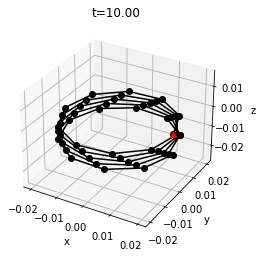

Current time:  10.09999999999998
Current time:  10.19999999999998
Current time:  10.29999999999998
Current time:  10.399999999999979
Current time:  10.499999999999979
Current time:  10.599999999999978
Current time:  10.699999999999978
Current time:  10.799999999999978
Current time:  10.899999999999977
Current time:  10.999999999999977
Current time:  11.099999999999977
Current time:  11.199999999999976
Current time:  11.299999999999976
Current time:  11.399999999999975
Current time:  11.499999999999975
Current time:  11.599999999999975
Current time:  11.699999999999974
Current time:  11.799999999999974
Current time:  11.899999999999974
Current time:  11.999999999999973
Current time:  12.099999999999973
Current time:  12.199999999999973
Current time:  12.299999999999972
Current time:  12.399999999999972
Current time:  12.499999999999972
Current time:  12.599999999999971
Current time:  12.69999999999997
Current time:  12.79999999999997
Current time:  12.89999999999997
Current time:  12.99

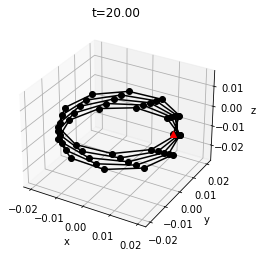

Current time:  20.100000000000016
Current time:  20.200000000000017
Current time:  20.30000000000002
Current time:  20.40000000000002
Current time:  20.50000000000002
Current time:  20.600000000000023
Current time:  20.700000000000024
Current time:  20.800000000000026
Current time:  20.900000000000027
Current time:  21.00000000000003
Current time:  21.10000000000003
Current time:  21.20000000000003
Current time:  21.300000000000033
Current time:  21.400000000000034
Current time:  21.500000000000036
Current time:  21.600000000000037
Current time:  21.70000000000004
Current time:  21.80000000000004
Current time:  21.90000000000004
Current time:  22.000000000000043
Current time:  22.100000000000044
Current time:  22.200000000000045
Current time:  22.300000000000047
Current time:  22.40000000000005
Current time:  22.50000000000005
Current time:  22.60000000000005
Current time:  22.700000000000053
Current time:  22.800000000000054
Current time:  22.900000000000055
Current time:  23.00000000

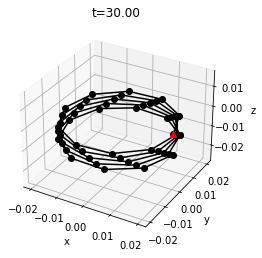

Current time:  30.100000000000158
Current time:  30.20000000000016
Current time:  30.30000000000016
Current time:  30.400000000000162
Current time:  30.500000000000163
Current time:  30.600000000000165
Current time:  30.700000000000166
Current time:  30.800000000000168
Current time:  30.90000000000017
Current time:  31.00000000000017
Current time:  31.100000000000172
Current time:  31.200000000000173
Current time:  31.300000000000175
Current time:  31.400000000000176
Current time:  31.500000000000178
Current time:  31.60000000000018
Current time:  31.70000000000018
Current time:  31.800000000000182
Current time:  31.900000000000183
Current time:  32.000000000000185
Current time:  32.100000000000186
Current time:  32.20000000000019
Current time:  32.30000000000019
Current time:  32.40000000000019
Current time:  32.50000000000019
Current time:  32.60000000000019
Current time:  32.700000000000195
Current time:  32.800000000000196
Current time:  32.9000000000002
Current time:  33.000000000

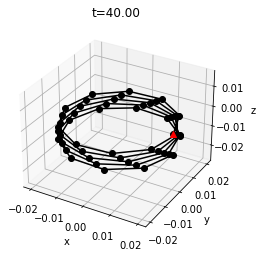

Current time:  40.1000000000003
Current time:  40.2000000000003
Current time:  40.3000000000003
Current time:  40.400000000000304
Current time:  40.500000000000306
Current time:  40.60000000000031
Current time:  40.70000000000031
Current time:  40.80000000000031
Current time:  40.90000000000031
Current time:  41.00000000000031
Current time:  41.100000000000314
Current time:  41.200000000000315
Current time:  41.30000000000032
Current time:  41.40000000000032
Current time:  41.50000000000032
Current time:  41.60000000000032
Current time:  41.70000000000032
Current time:  41.800000000000324
Current time:  41.900000000000325
Current time:  42.00000000000033
Current time:  42.10000000000033
Current time:  42.20000000000033
Current time:  42.30000000000033
Current time:  42.40000000000033
Current time:  42.500000000000334
Current time:  42.600000000000335
Current time:  42.70000000000034
Current time:  42.80000000000034
Current time:  42.90000000000034
Current time:  43.00000000000034
Curre

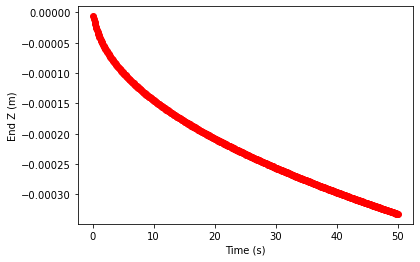

In [144]:
Nsteps = round(totalTime / dt ) # number of steps
ctime = 0 # Current time
endZ_0 = qOld[-1] # End Z coordinate of the first node
endZ = np.zeros(Nsteps)

a1_old = a1
a2_old = a2

for timeStep in range(Nsteps):

  print('Current time: ', ctime)

  q_new, u_new, a1_new, a2_new, flag = objfun(qOld, uOld, a1_old, a2_old,
                                        freeIndex, dt, tol, refTwist,
                                        massVector, massMatrix,
                                        EA, refLen,
                                        EI, GJ, voronoiRefLen,
                                        kappaBar, twistBar,
                                        Fg)
  if flag == False:
    print('Maximum number of iterations reached')
    break
  # Save endZ (z coordinate of the last node)
  endZ[timeStep] = q_new[-1] - endZ_0

  if timeStep % snapshotInterval == 0:
    plotrod_simple(q_new, ctime)

  ctime += dt # Current time

  if ctime == totalTime:
    plotrod_simple(q_new, ctime)
     
  # Old parameters become new
  qOld = q_new.copy()
  uOld = u_new.copy()
  a1_old = a1_new.copy()
  a2_old = a2_new.copy()

plt.figure(2)
time_array = np.arange(1, Nsteps+1, 1) * dt
plt.plot(time_array, endZ, 'ro-')
plt.xlabel('Time (s)')
plt.ylabel('End Z (m)')
plt.show()

**Notes**
At $D=0.04$ m, $\delta_{z, end} \sim 0.0025$ m

$$
k \sim \frac{1}{D^3}
$$

If we increase $D$ by $1.5$, we should expect the deformation to increase by $1.5^3 = 3.375$.

$D = 1.5 \times 0.04 = 0.06$ should lead to $\delta_{z, end} \sim 0.0025 * 3.375 = 0.0084$ m